# Fase 4: Busca de Parâmetros

Nesta fase iremos aprofundar a busca de hiperparamewtros, variabndo os parametros ca cada modelos, e compaerandos seus resultados

O primeiro passo que iremos fazer é importar as bibliotecas principais, e estabelecer o ambiente de execução.


In [ ]:
# Bibliotecas Externas
import os
import warnings
import pandas as pd
import numpy as np
import pickle
import time

from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Ignorando Warnings
warnings.filterwarnings("ignore")

# Bibliotecas Locais
os.chdir("../..")

# Definido Variáveis globais
N_SPLITS = 10
N_ITER = 20
RANDOM_STATE = 51

## 0. Funções Base

In [2]:
def plot_confusion_matrix(cm, title="Matriz de Confusão"):
    cm = np.array(cm)  # Garante que a matriz esteja no formato correto

    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=[str(i) for i in range(len(cm))],
                yticklabels=[str(i) for i in range(len(cm))])

    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [3]:
def plot_roc_curve(fpr, tpr, auc_score, title="Curva ROC"):
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Aleatório')
    plt.xlabel("FPR (Taxa de Falsos Positivos)")
    plt.ylabel("TPR (Taxa de Verdadeiros Positivos)")
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def get_model_metrics(model, model_name, X_train, Y_train, X_val, Y_val, X_test, Y_test):
    # Avaliação dos modelos e adição ao DataFrame
    print(f"🔍 Avaliando modelo {model_name}...")

    # Previsões
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)

    # Probabilidades para AUC-ROC
    Y_prob_train = model.predict_proba(X_train)[:, 1]
    Y_prob_val = model.predict_proba(X_val)[:, 1]
    Y_prob_test = model.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr_train, tpr_train, _ = roc_curve(Y_train, Y_prob_train)
    fpr_val, tpr_val, _ = roc_curve(Y_val, Y_prob_val)
    fpr_test, tpr_test, _ = roc_curve(Y_test, Y_prob_test)

    # Matriz de Confusão
    cm_train = confusion_matrix(Y_train, Y_pred_train)
    cm_val = confusion_matrix(Y_val, Y_pred_val)
    cm_test = confusion_matrix(Y_test, Y_pred_test)

    # Salvando resultados no DataFrame
    df_results = pd.DataFrame([
        {
            "Data": "Train",
            "Accuracy": accuracy_score(Y_train, Y_pred_train),
            "F1_Score": f1_score(Y_train, Y_pred_train),
            "Recall": recall_score(Y_train, Y_pred_train),
            "Precision": precision_score(Y_train, Y_pred_train),
            "AUC_ROC": roc_auc_score(Y_train, Y_prob_train),
            "Confusion_Matrix": [cm_train],
            "FPR": [fpr_train],
            "TPR": [tpr_train]
        },
        {
            "Data": "Validation",
            "Accuracy": accuracy_score(Y_val, Y_pred_val),
            "F1_Score": f1_score(Y_val, Y_pred_val),
            "Recall": recall_score(Y_val, Y_pred_val),
            "Precision": precision_score(Y_val, Y_pred_val),
            "AUC_ROC": roc_auc_score(Y_val, Y_prob_val),
            "Confusion_Matrix": [cm_val],
            "FPR": [fpr_val],
            "TPR": [tpr_val],
        },
        {
            "Data": "Test",
            "Accuracy": accuracy_score(Y_test, Y_pred_test),
            "F1_Score": f1_score(Y_test, Y_pred_test),
            "Recall": recall_score(Y_test, Y_pred_test),
            "Precision": precision_score(Y_test, Y_pred_test),
            "AUC_ROC": roc_auc_score(Y_test, Y_prob_test),
            "Confusion_Matrix": [cm_test],
            "FPR": [fpr_test],
            "TPR": [tpr_test]
        }
    ])

    return df_results

## 1. Importando os Dados

Nosso primero é coletar os dados que preparamos na etapa anterior, para verificar como esses dados se comportam

In [5]:
# Conjunto de treino
X_train = pd.read_csv('./data/processed/X_train.csv')
Y_train = pd.read_csv('./data/processed/Y_train.csv')

Y_train['class'] = Y_train['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de validação
X_val = pd.read_csv('./data/processed/X_val.csv')
Y_val = pd.read_csv('./data/processed/Y_val.csv')


Y_val['class'] = Y_val['class'].apply(lambda val: 1 if val == 'UP' else 0)

# Conjunto de teste
X_test = pd.read_csv('./data/processed/X_test.csv')
Y_test = pd.read_csv('./data/processed/Y_test.csv')

Y_test['class'] = Y_test['class'].apply(lambda val: 1 if val == 'UP' else 0)

## 2. Algoritmos de Machine Learning para Classificação

### 2.1 Stacking (Sem busca de Hiperparâmetros)

In [6]:
# Configuração da validação cruzada estratificada k-fold
cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [7]:
# Definição dos modelos base
base_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('decision_tree', DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)),
    ('random_forest', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=RANDOM_STATE)),
    ('naive_bayes', GaussianNB()),
    ('logistic_regression', LogisticRegression(C=1.0, solver='liblinear', random_state=RANDOM_STATE))
]

# Meta-modelo (nível superior)
meta_model = LogisticRegression()

In [8]:
# Criando o Stacking Classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=cv_strategy, n_jobs=-1)

In [9]:
# Treinando o modelo

stacking_clf.fit(X_train, Y_train)

StackingClassifier(cv=StratifiedKFold(n_splits=10, random_state=51, shuffle=True),
                   estimators=[('knn', KNeighborsClassifier()),
                               ('decision_tree',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=51)),
                               ('random_forest',
                                RandomForestClassifier(max_depth=5,
                                                       n_estimators=50,
                                                       random_state=51)),
                               ('naive_bayes', GaussianNB()),
                               ('logistic_regression',
                                LogisticRegression(random_state=51,
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

#### Métricas

In [10]:
# Avaliando o modelo treinado
df_base_results = get_model_metrics(stacking_clf, "StackingClassifierNoRandom", X_train, Y_train, X_val, Y_val, X_test, Y_test)

🔍 Avaliando modelo StackingClassifierNoRandom...


In [11]:
df_base_results

,Data,Accuracy,F1_Score,Recall,Precision,AUC_ROC,Confusion_Matrix,FPR,TPR
0,Train,0.880744,0.854573,0.838544,0.871227,0.950808,"[[[10353, 1011], [1317, 6840]]]","[[0.0, 0.0, 0.0, 8.799718409010911e-05, 8.7997...","[[0.0, 0.0001225940909648155, 0.18854971190388..."
1,Validation,0.834329,0.798018,0.776077,0.821236,0.904749,"[[[2121, 298], [395, 1369]]]","[[0.0, 0.0, 0.0, 0.00041339396444811904, 0.000...","[[0.0, 0.0005668934240362812, 0.10827664399092..."
2,Test,0.837476,0.798100,0.787346,0.809151,0.907480,"[[[2160, 317], [363, 1344]]]","[[0.0, 0.0, 0.0, 0.0004037141703673799, 0.0004...","[[0.0, 0.0005858230814294083, 0.11599297012302..."


### Matriz de confusão

Treino

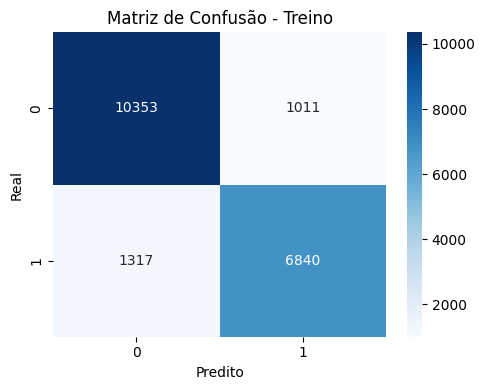

In [12]:
plot_confusion_matrix(df_base_results.loc[0, "Confusion_Matrix"][0], "Matriz de Confusão - Treino")

Validação

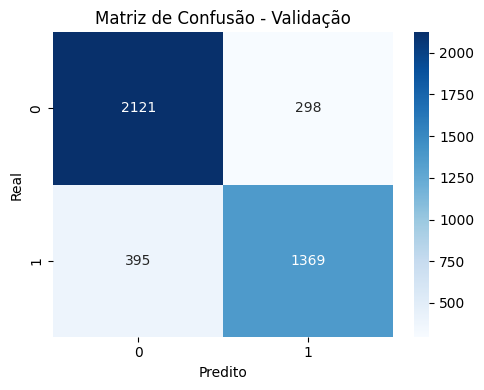

In [13]:
plot_confusion_matrix(df_base_results.loc[1, "Confusion_Matrix"][0], "Matriz de Confusão - Validação")

Teste

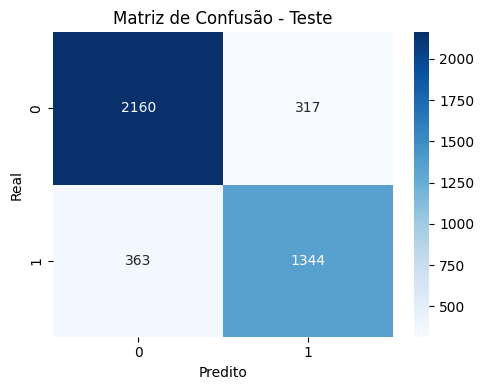

In [14]:
plot_confusion_matrix(df_base_results.loc[2, "Confusion_Matrix"][0], "Matriz de Confusão - Teste")

#### Curva ROC

Treino

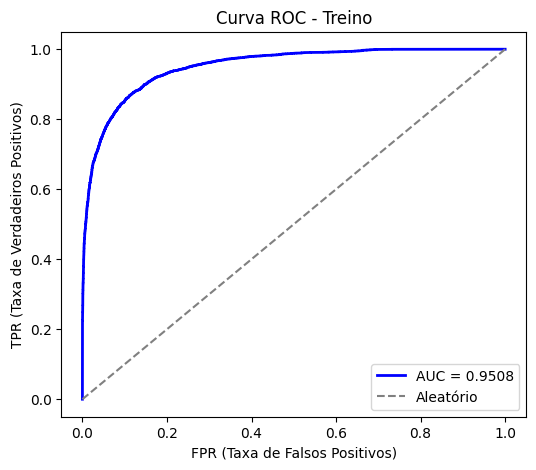

In [15]:
plot_roc_curve(
    df_base_results.loc[0, "FPR"][0], 
    df_base_results.loc[0, "TPR"][0],
    df_base_results.loc[0, "AUC_ROC"],
    "Curva ROC - Treino"
)

Validação

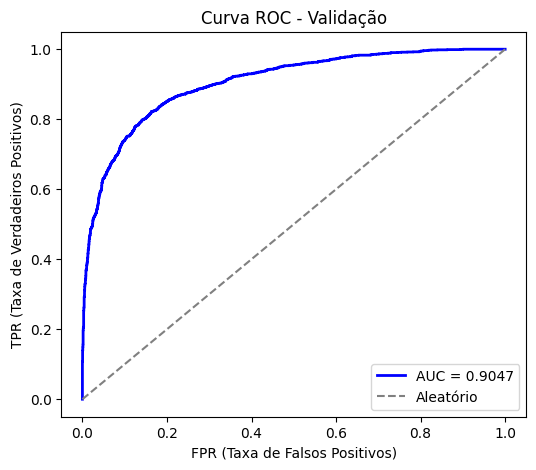

In [16]:
plot_roc_curve(
    df_base_results.loc[1, "FPR"][0],
    df_base_results.loc[1, "TPR"][0],
    df_base_results.loc[1, "AUC_ROC"],
    "Curva ROC - Validação"
)

Teste

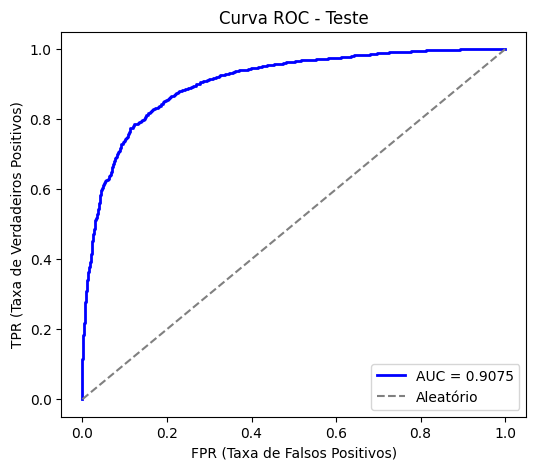

In [17]:
plot_roc_curve(
    df_base_results.loc[2,"FPR"][0],
    df_base_results.loc[2, "TPR"][0],
    df_base_results.loc[2, "AUC_ROC"],
    "Curva ROC - Teste"
)

### 1.2 Com RandomizedSearchCV

In [18]:
# Definição da validação cruzada estratificada
cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

In [19]:
# Dicionário de hiperparâmetros para cada modelo base
param_grids = {
    'knn': {'n_neighbors': randint(3, 15), 'weights': ['uniform', 'distance']},
    'decision_tree': {'max_depth': randint(3, 20), 'criterion': ['gini', 'entropy']},
    'random_forest': {'n_estimators': randint(10, 100), 'max_depth': randint(3, 15)},
    'naive_bayes': {},  # Não há hiperparâmetros ajustáveis no GaussianNB padrão
    'logistic_regression': {'C': uniform(0.1, 10), 'solver': ['liblinear', 'lbfgs']}
}

In [20]:
# Dicionário para armazenar os melhores modelos
best_models = {}

In [21]:
# Aplicando RandomizedSearchCV para encontrar os melhores hiperparâmetros
for name, model in [
    ('knn', KNeighborsClassifier()),
    ('decision_tree', DecisionTreeClassifier(random_state=RANDOM_STATE)),
    ('random_forest', RandomForestClassifier(random_state=RANDOM_STATE)),
    ('naive_bayes', GaussianNB()),
    ('logistic_regression', LogisticRegression(random_state=RANDOM_STATE))
]:
    print(f"\n🔍 Otimizando {name}...")
    rand_search = RandomizedSearchCV(model, param_grids[name], n_iter=20, cv=cv_strategy, n_jobs=-1, random_state=RANDOM_STATE)
    rand_search.fit(X_train, Y_train)
    best_models[name] = rand_search.best_estimator_
    print(f"✅ Melhor modelo {name}: {rand_search.best_params_}")


🔍 Otimizando knn...
✅ Melhor modelo knn: {'n_neighbors': 3, 'weights': 'distance'}

🔍 Otimizando decision_tree...
✅ Melhor modelo decision_tree: {'criterion': 'entropy', 'max_depth': 19}

🔍 Otimizando random_forest...
✅ Melhor modelo random_forest: {'max_depth': 14, 'n_estimators': 77}

🔍 Otimizando naive_bayes...
✅ Melhor modelo naive_bayes: {}

🔍 Otimizando logistic_regression...
✅ Melhor modelo logistic_regression: {'C': np.float64(9.689885320465102), 'solver': 'lbfgs'}


In [22]:
# Criando o Stacking Classifier com os melhores modelos encontrados
base_models = [(name, model) for name, model in best_models.items()]
meta_model = LogisticRegression()

In [23]:
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=cv_strategy, n_jobs=-1)

In [24]:
# Treinando o StackingClassifier
print("\n🚀 Treinando StackingClassifier...")
stacking_clf.fit(X_train, Y_train)


🚀 Treinando StackingClassifier...


StackingClassifier(cv=StratifiedKFold(n_splits=10, random_state=51, shuffle=True),
                   estimators=[('knn',
                                KNeighborsClassifier(n_neighbors=3,
                                                     weights='distance')),
                               ('decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=19,
                                                       random_state=51)),
                               ('random_forest',
                                RandomForestClassifier(max_depth=14,
                                                       n_estimators=77,
                                                       random_state=51)),
                               ('naive_bayes', GaussianNB()),
                               ('logistic_regression',
                                LogisticRegression(C=np.float64(9.689885320465102),
                                                   random_state=51))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

#### Métricas

In [25]:
df_final_results = get_model_metrics(stacking_clf, "CLF", X_train, Y_train, X_val, Y_val, X_test, Y_test)

🔍 Avaliando modelo CLF...


In [26]:
df_final_results

,Data,Accuracy,F1_Score,Recall,Precision,AUC_ROC,Confusion_Matrix,FPR,TPR
0,Train,0.998258,0.997915,0.997671,0.998160,0.999982,"[[[11349, 15], [19, 8138]]]","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0001225940909648155, 0.42307220791957..."
1,Validation,0.890509,0.869068,0.861678,0.876586,0.957898,"[[[2205, 214], [244, 1520]]]","[[0.0, 0.0, 0.0, 0.00041339396444811904, 0.000...","[[0.0, 0.0005668934240362812, 0.16269841269841..."
2,Test,0.896989,0.871917,0.859402,0.884801,0.959131,"[[[2286, 191], [240, 1467]]]","[[0.0, 0.0, 0.0, 0.0004037141703673799, 0.0004...","[[0.0, 0.0005858230814294083, 0.03222026947861..."


### Matriz de confusão

Treino

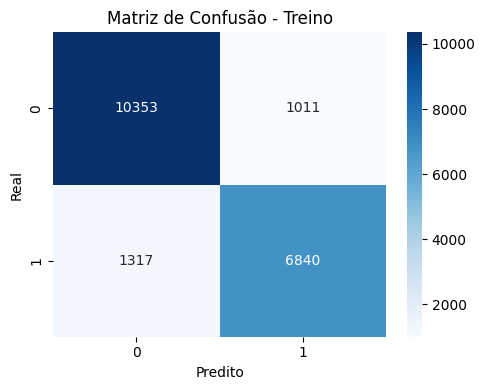

In [27]:
plot_confusion_matrix(df_base_results.loc[0, "Confusion_Matrix"][0], "Matriz de Confusão - Treino")

Validação

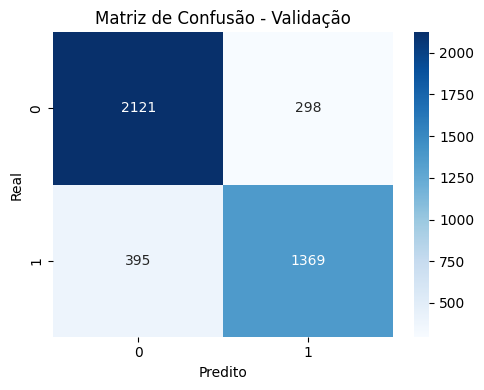

In [28]:
plot_confusion_matrix(df_base_results.loc[1, "Confusion_Matrix"][0], "Matriz de Confusão - Validação")

Teste

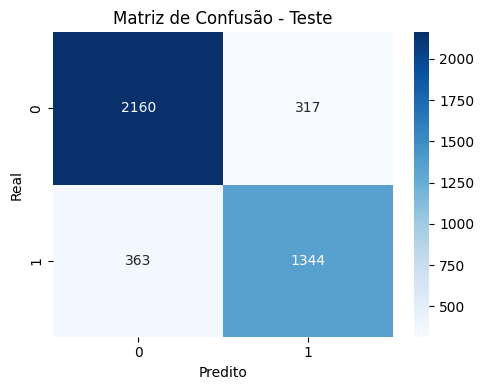

In [29]:
plot_confusion_matrix(df_base_results.loc[2, "Confusion_Matrix"][0], "Matriz de Confusão - Teste")

#### Curva ROC

Treino

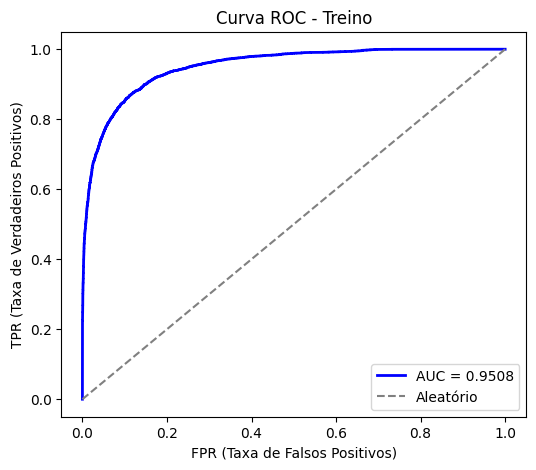

In [30]:
plot_roc_curve(
    df_base_results.loc[0, "FPR"][0], 
    df_base_results.loc[0, "TPR"][0],
    df_base_results.loc[0, "AUC_ROC"],
    "Curva ROC - Treino"
)

Validação

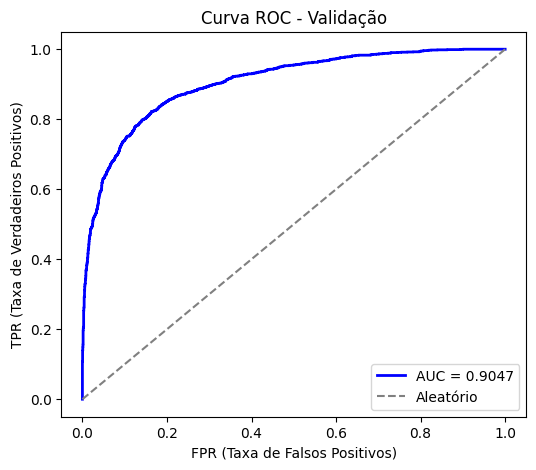

In [31]:
plot_roc_curve(
    df_base_results.loc[1, "FPR"][0],
    df_base_results.loc[1, "TPR"][0],
    df_base_results.loc[1, "AUC_ROC"],
    "Curva ROC - Validação"
)

Teste

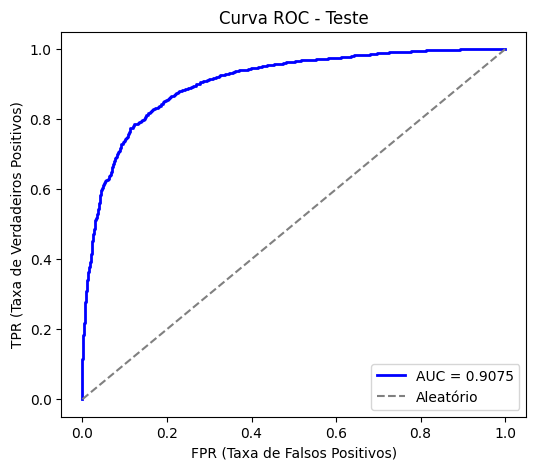

In [32]:
plot_roc_curve(
    df_base_results.loc[2,"FPR"][0],
    df_base_results.loc[2, "TPR"][0],
    df_base_results.loc[2, "AUC_ROC"],
    "Curva ROC - Teste"
)

### 1.3 Achando os 20 melhores modelos

In [33]:
model_list = {
    'knn': lambda rs: KNeighborsClassifier(),
    'decision_tree': lambda rs: DecisionTreeClassifier(random_state=rs),
    'random_forest': lambda rs: RandomForestClassifier(random_state=rs),
    'naive_bayes': lambda rs: GaussianNB(),
    'logistic_regression': lambda rs: LogisticRegression(random_state=rs)
}


In [35]:
checkpoint_path = "./models/stacking.pkl"
history_path = "./data/results/stacking.pkl"

In [36]:
# Verifica se há um checkpoint salvo
if os.path.exists(checkpoint_path):
    with open(checkpoint_path, "rb") as f:
        best_models = pickle.load(f)
    with open(history_path, "rb") as f:
        performance_history = pickle.load(f)
    start_iter = len(best_models)
else:
    best_models = {}
    performance_history = {}
    start_iter = 0

In [ ]:
# Loop para otimizar cada modelo
for model_name, model_func in model_list.items():
    print(f"\n Otimizando {model_name}...")

    # Inicializa histórico para esse modelo, se necessário
    if model_name not in performance_history:
        performance_history[model_name] = []

    for i in range(start_iter, N_ITER):
        print(f"Execução {i+1} para {model_name}")

        # Criando o modelo com random_state dinâmico
        model = model_func(RANDOM_STATE+i)

        # Estratégia de validação cruzada
        cv_strategy = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE + i)
        rand_search = RandomizedSearchCV(model, param_grids[model_name], n_iter=20, cv=cv_strategy,
                                         n_jobs=-1, random_state=RANDOM_STATE+i, return_train_score=True)

        # Treinando
        print("Treinando...")

        start_time = time.time()
        rand_search.fit(X_train, Y_train.values.ravel())
        end_time = time.time()
        elapsed_time = end_time - start_time

        print(f"Tempo de execução: {elapsed_time:.4f} segundos")

        # Armazena histórico de desempenho
        mean_test_scores = np.mean(rand_search.cv_results_['mean_test_score'])
        std_test_scores = np.std(rand_search.cv_results_['std_test_score'])
        performance_history[model_name].append((mean_test_scores, std_test_scores))

        # Guarda o melhor modelo encontrado
        best_models[model_name] = rand_search.best_estimator_
        print(f"✅ Melhor modelo salvo para {model_name}")

        # Salvar progresso
        with open(checkpoint_path, "wb") as f:
            pickle.dump(best_models, f)
        with open(history_path, "wb") as f:
            pickle.dump(performance_history, f)

print("\n🏆 Otimização concluída!")


 Otimizando knn...
Execução 1 para knn
Treinando...
Tempo de execução: 30.2150 segundos
✅ Melhor modelo salvo para knn
Execução 2 para knn
Treinando...
Tempo de execução: 23.4819 segundos
✅ Melhor modelo salvo para knn
Execução 3 para knn
Treinando...
Tempo de execução: 27.8969 segundos
✅ Melhor modelo salvo para knn
Execução 4 para knn
Treinando...
Tempo de execução: 25.1305 segundos
✅ Melhor modelo salvo para knn
Execução 5 para knn
Treinando...
Tempo de execução: 25.4835 segundos
✅ Melhor modelo salvo para knn
Execução 6 para knn
Treinando...
Tempo de execução: 26.0200 segundos
✅ Melhor modelo salvo para knn
Execução 7 para knn
Treinando...
Tempo de execução: 23.8765 segundos
✅ Melhor modelo salvo para knn
Execução 8 para knn
Treinando...
Tempo de execução: 27.6767 segundos
✅ Melhor modelo salvo para knn
Execução 9 para knn
Treinando...
Tempo de execução: 25.3874 segundos
✅ Melhor modelo salvo para knn
Execução 10 para knn
Treinando...
Tempo de execução: 26.2799 segundos
✅ Melhor m

In [44]:
# Criando o Stacking Classifier com os melhores modelos encontrados
base_models = [(name, model) for name, model in best_models.items()]
meta_model = LogisticRegression()

In [45]:
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=cv_strategy, n_jobs=-1)

In [46]:
# Treinando o StackingClassifier
print("\n🚀 Treinando StackingClassifier...")
stacking_clf.fit(X_train, Y_train)


🚀 Treinando StackingClassifier...


StackingClassifier(cv=StratifiedKFold(n_splits=10, random_state=60, shuffle=True),
                   estimators=[('knn',
                                KNeighborsClassifier(weights='distance')),
                               ('decision_tree',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=16,
                                                       random_state=60)),
                               ('random_forest',
                                RandomForestClassifier(max_depth=13,
                                                       n_estimators=46,
                                                       random_state=60)),
                               ('naive_bayes', GaussianNB()),
                               ('logistic_regression',
                                LogisticRegression(C=np.float64(9.583597996508846),
                                                   random_state=60,
                                                   solver='liblinear'))],
                   final_estimator=LogisticRegression(), n_jobs=-1)

### Métricas

In [70]:
df_results = pd.DataFrame(columns=[
    "Model",
    "Accuracy_Train", "Accuracy_Val", "Accuracy_Test",
    "F1_Score_Train", "F1_Score_Val", "F1_Score_Test",
    "Recall_Train", "Recall_Val", "Recall_Test",
    "Precision_Train", "Precision_Val", "Precision_Test",
    "AUC_ROC_Train", "AUC_ROC_Val", "AUC_ROC_Test",
    "Confusion_Matrix_Train", "Confusion_Matrix_Val", "Confusion_Matrix_Test"
])

In [71]:
# Avaliação dos modelos e adição ao DataFrame
df_results_new = []  # Lista para armazenar os resultados

for name, model in best_models.items():
    print(f"🔍 Avaliando modelo {name}...")

    # Previsões
    Y_pred_train = model.predict(X_train)
    Y_pred_val = model.predict(X_val)
    Y_pred_test = model.predict(X_test)

    # Probabilidades para AUC-ROC
    Y_prob_train = model.predict_proba(X_train)[:, 1]
    Y_prob_val = model.predict_proba(X_val)[:, 1]
    Y_prob_test = model.predict_proba(X_test)[:, 1]

    # Curva ROC
    fpr_train, tpr_train, _ = roc_curve(Y_train, Y_prob_train)
    fpr_val, tpr_val, _ = roc_curve(Y_val, Y_prob_val)
    fpr_test, tpr_test, _ = roc_curve(Y_test, Y_prob_test)

    # Matriz de Confusão
    cm_train = confusion_matrix(Y_train, Y_pred_train)
    cm_val = confusion_matrix(Y_val, Y_pred_val)
    cm_test = confusion_matrix(Y_test, Y_pred_test)

    # Adiciona os resultados à lista
    df_results_new.append({
        "Model": name,
        "Accuracy_Train": accuracy_score(Y_train, Y_pred_train),
        "Accuracy_Val": accuracy_score(Y_val, Y_pred_val),
        "Accuracy_Test": accuracy_score(Y_test, Y_pred_test),
        "F1_Score_Train": f1_score(Y_train, Y_pred_train),
        "F1_Score_Val": f1_score(Y_val, Y_pred_val),
        "F1_Score_Test": f1_score(Y_test, Y_pred_test),
        "Recall_Train": recall_score(Y_train, Y_pred_train),
        "Recall_Val": recall_score(Y_val, Y_pred_val),
        "Recall_Test": recall_score(Y_test, Y_pred_test),
        "Precision_Train": precision_score(Y_train, Y_pred_train),
        "Precision_Val": precision_score(Y_val, Y_pred_val),
        "Precision_Test": precision_score(Y_test, Y_pred_test),
        "AUC_ROC_Train": roc_auc_score(Y_train, Y_prob_train),
        "AUC_ROC_Val": roc_auc_score(Y_val, Y_prob_val),
        "AUC_ROC_Test": roc_auc_score(Y_test, Y_prob_test),
        "Confusion_Matrix_Train": [cm_train],
        "Confusion_Matrix_Val": [cm_val],
        "Confusion_Matrix_Test": [cm_test],
        "FPR_Train": [fpr_train],
        "TPR_Train": [tpr_train],
        "FPR_Val": [fpr_val],
        "TPR_Val": [tpr_val],
        "FPR_Test": [fpr_test],
        "TPR_Test": [tpr_test]
    })

# Converte a lista para um DataFrame e concatena com o original
df_results_new = pd.DataFrame(df_results_new)
df_results = pd.concat([df_results, df_results_new], ignore_index=True)

🔍 Avaliando modelo knn...
🔍 Avaliando modelo decision_tree...
🔍 Avaliando modelo random_forest...
🔍 Avaliando modelo naive_bayes...
🔍 Avaliando modelo logistic_regression...


### Matriz de confusão

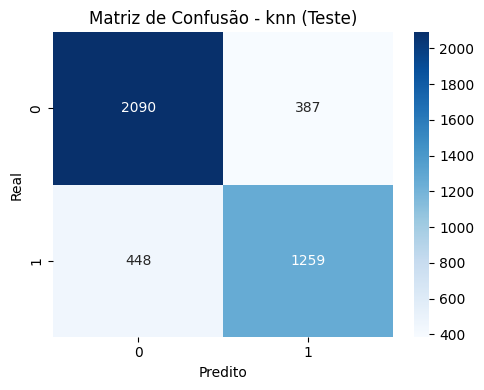

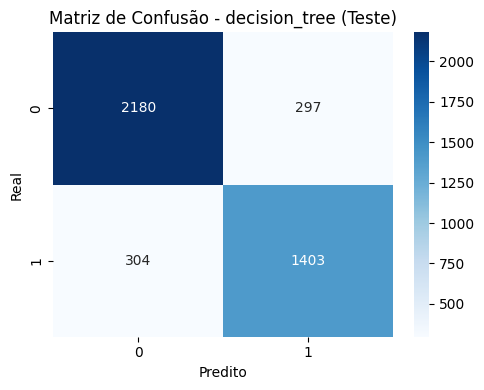

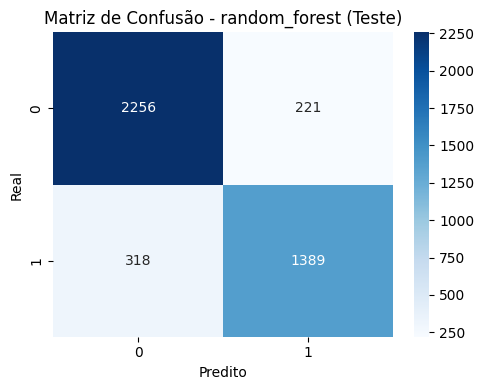

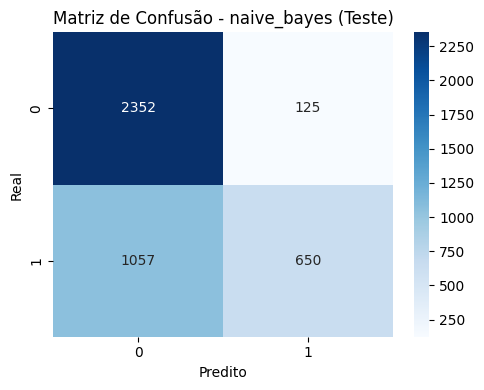

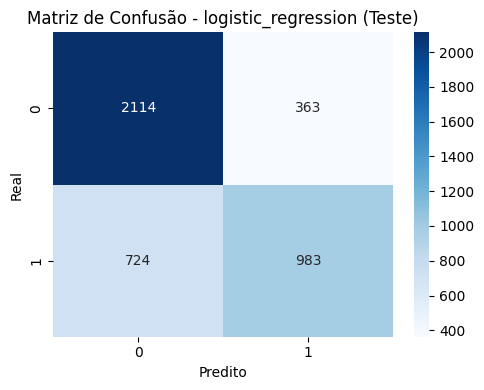

In [ ]:
for i in range(len(df_results)):
    name = df_results.loc[i, "Model"]

    plot_confusion_matrix(df_results.loc[i, "Confusion_Matrix_Test"][0], f"Matriz de Confusão - {name} (Teste)")


### Curva ROC

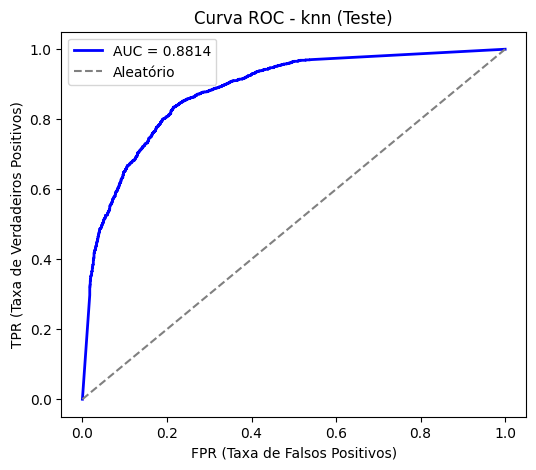

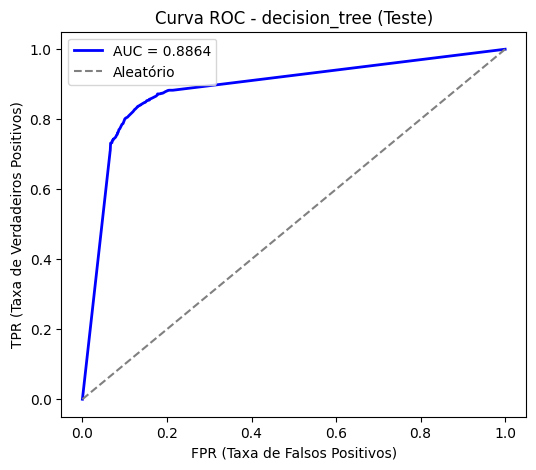

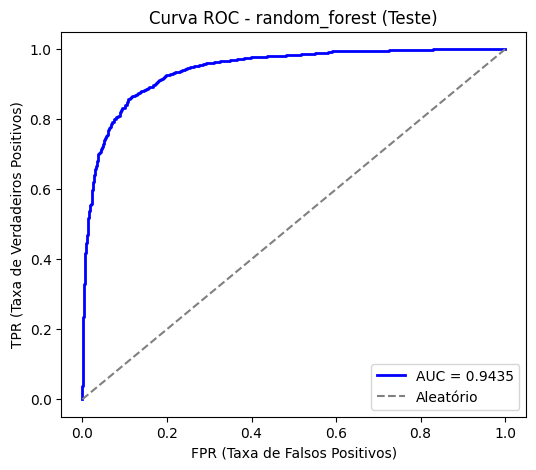

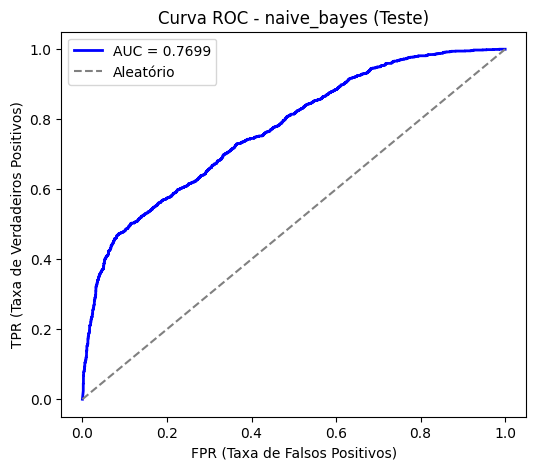

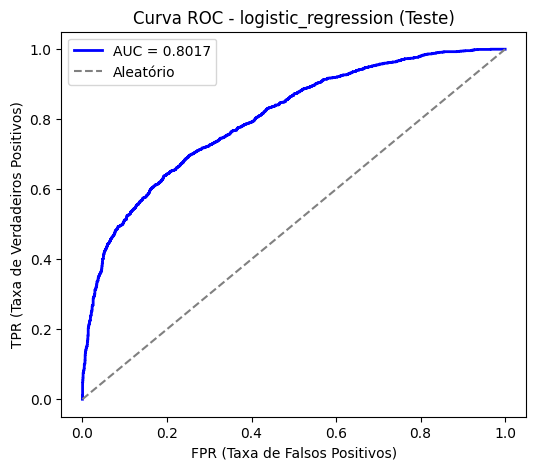

In [ ]:
for i in range(len(df_results)):
    name = df_results.loc[i, "Model"]

    plot_roc_curve(df_results.loc[i, "FPR_Test"][0], df_results.loc[i, "TPR_Test"][0], df_results.loc[i, "AUC_ROC_Test"], f"Curva ROC - {name} (Teste)")

### Melhor modelo encontrado

In [82]:
# Encontrando o melhor modelo com base no maior mean_test_score
best_model_name = None
best_score = -np.inf  # Inicia com um valor muito baixo
best_index = -1

for model_name, results in performance_history.items():
    for idx, (mean_score, std_score) in enumerate(results):
        if mean_score > best_score:  # Comparando a melhor média
            best_score = mean_score
            best_model_name = model_name
            best_index = idx

# Exibindo o melhor modelo
print("\n🏆 Melhor modelo encontrado:")
print(f"Modelo: {best_model_name}")
print(f"Execução #{best_index + 1}")
print(f"Média do Score de Teste: {best_score:.4f}")
print(f"Desvio Padrão: {performance_history[best_model_name][best_index][1]:.4f}")

# Recuperando o melhor modelo salvo
best_overall_model = best_models[best_model_name]


🏆 Melhor modelo encontrado:
Modelo: decision_tree
Execução #5
Média do Score de Teste: 0.8304
Desvio Padrão: 0.0017


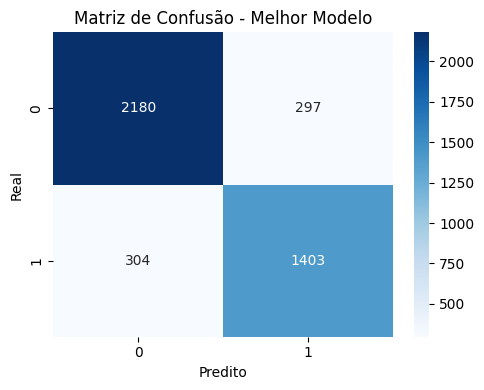

In [85]:
cm = confusion_matrix(Y_test, best_overall_model.predict(X_test))
plot_confusion_matrix(cm, title="Matriz de Confusão - Melhor Modelo")

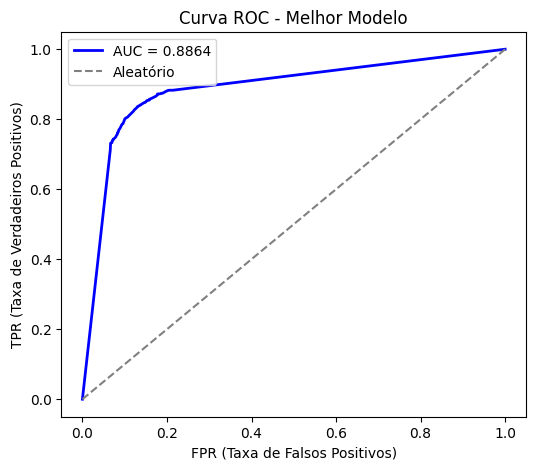

In [86]:
fpr, tpr, _ = roc_curve(Y_test, best_overall_model.predict_proba(X_test)[:, 1])
auc_score = roc_auc_score(Y_test, best_overall_model.predict_proba(X_test)[:, 1])
plot_roc_curve(fpr, tpr, auc_score, title="Curva ROC - Melhor Modelo")